# Milestone 3: Machine Learning 

**Author:** Surbhi Kapoor     
**Date:** 11-02-2025

## Overiew 
Now that we have completed EDA and I have a pretty good idea of what the features our like, the response encodings, imbalances and geenral insights. I am now ready to use this cleaned and analyzed data with all the EDA knowledge gained to experiment with and come up with a final model that does what my Research Question states, which is to make, with at least 70% accuracy (on entire dataset), predictions on the psychological distress level of a given survey taker.

While I want to keep it a binary target variable for simplicity I would also like to indulge for experimentation puposes into the idea of having the classification target variables as 3-5 distinct labels, categorizing the severity or the "profile" of said candidate. This is a decision I will refine as I experiement with the data and various combinations of models and subsets of features. 

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score, f1_score, make_scorer,
                             roc_curve, precision_recall_curve, accuracy_score, balanced_accuracy_score,
                            average_precision_score,
                            confusion_matrix, ConfusionMatrixDisplay)
                            


In [114]:
def load_variable_dictionary():
    """Load NHIS variable dictionary for readable names"""
    try:
        with open('nhis_variable_dictionary.json', 'r') as f:
            var_dict = json.load(f)
        print(f"✓ Dictionary loaded: {len(var_dict)} variables mapped")
        return var_dict
    except FileNotFoundError:
        print("⚠ Warning: Variable dictionary not found.")
        print("Run the dictionary creator script first, or continue with original names.")
        return 
        
# I will conert column names so I can understand what is going on 
def get_readable_name(code, var_dict):
    """Get readable name for a variable code"""
    return var_dict.get(code, code)

def format_column_names(df, columns, var_dict):
    """Create a mapping of original to readable names for given columns"""
    return {col: get_readable_name(col, var_dict) for col in columns}

# Load the dictionary
var_dict = load_variable_dictionary()

fatigue_vars = {
    'FGEFRQTRD_A': 'Fatigue: Frequency of feeling tired/exhausted (past 3 months)',
    'FGELNGTRD_A': 'Fatigue: Duration of tiredness periods',
}

# Update your dictionary
var_dict.update(fatigue_vars)

✓ Dictionary loaded: 363 variables mapped


In [4]:
value_labels = {
    'SEX_A': {1: 'Male', 2: 'Female'},
    
    'HISPALLP_A': {
        1: 'Hispanic',
        2: 'NH White',
        3: 'NH Black',
        4: 'NH Asian',
        5: 'NH AIAN',
        6: 'NH AIAN+Other',
        7: 'Other/Multiple'
    },
    
    'EDUCP_A': {
        1: 'Grade 1-11',
        2: '12th, no diploma',
        3: 'GED',
        4: 'HS Graduate',
        5: 'Some college',
        6: 'Assoc (voc)',
        7: 'Assoc (acad)',
        8: "Bachelor's",
        9: "Master's",
        10: 'Prof/Doctoral'
    },
    
    'MARITAL_A': {
        1: 'Married',
        2: 'With partner',
        3: 'Widowed',
        4: 'Divorced',
        5: 'Separated',
        6: 'Never married'
    },
    
    'PHSTAT_A': {
        1: 'Excellent',
        2: 'Very Good',
        3: 'Good',
        4: 'Fair',
        5: 'Poor'
    },
    
    'LSATIS4_A': {
        1: 'Very satisfied',
        2: 'Satisfied',
        3: 'Dissatisfied',
        4: 'Very dissatisfied'
    },
    
    'SMKCIGST_A': {
        1: 'Current',
        2: 'Former',
        3: 'Never',
        4: 'Unknown'
    }
}

# Binary (Yes/No) variables - Code 1=Yes, 2=No
binary_labels = {1: 'Yes', 2: 'No'}

## Load and Preprocess Dataset 

Since I did all the heavy lifting and analyzing in the EDA notebook I am just going to copy over the code from there that drops missing values > 70% columns, Fills in the nans where needed, imputes the values, constructs the new K6_Scorre column by re-encodin the 6 features to a 0-4 scoring scale. 

### Load Data

In [7]:
# Load dataset
df = pd.read_csv('adult24.csv')
df.head()

,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,PPSU,PSTRAT,WLKLEISTC_A,WLKTRANTC_A,HISPALLP_A,RACEALLP_A,ANYDIFF_A,...,LSATIS4_A,PHSTAT_A,HHSTAT_A,INTV_MON,RECTYPE,IMPNUM_A,AVGNUMCIG_A,WTFA_A,HHX,POVRATTC_A
0,9,0,2,2,122,NaN,NaN,2,1,2,...,1,1,1,1,10,1,30,5780.565,H067658,2.82
1,8,0,0,2,122,20.0,NaN,2,1,2,...,2,2,1,1,10,1,20,3994.244,H076577,2.01
2,7,0,0,2,122,30.0,NaN,2,1,1,...,1,2,1,1,10,1,20,6636.755,H019335,1.90
3,12,0,0,2,122,10.0,NaN,2,1,1,...,2,3,1,1,10,1,01,13767.420,H012701,4.48
4,14,0,0,1,115,NaN,NaN,3,2,1,...,2,3,1,1,10,1,NaN,18880.030,H049678,6.37


### Preprocessing: K6 Scale construction

In [9]:
df_clean = df.copy()

In [10]:
# K6 components
k6_vars = ['SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A']

# STEP 1: Recode to 0-4 scale (reverse the NHIS coding)
k6_recode = {
    5: 0,  # None of the time
    4: 1,  # A little
    3: 2,  # Some
    2: 3,  # Most
    1: 4,  # All of the time
    7: np.nan,  # Refused
    8: np.nan,  # Not ascertained
    9: np.nan   # Don't know
}

# Apply recoding to each K6 component
for var in k6_vars:
    df_clean[f'{var}_recoded'] = df_clean[var].map(k6_recode)

# STEP 2: Calculate K6 score (sum of all 6 components)
# Only calculate if ALL six components are non-missing
recoded_vars = [f'{var}_recoded' for var in k6_vars]
df_clean['K6_SCORE'] = df_clean[recoded_vars].sum(axis=1, min_count=6)  # min_count=6 means all must be non-null

# STEP 3: Create binary target (K6 >= 5 = eligible for preventative care)
df_clean['at_risk'] = (df_clean['K6_SCORE'] >= 5).astype(float)

print("\nK6 Score Statistics:")
print(df_clean['K6_SCORE'].describe())


K6 Score Statistics:
count    31813.000000
mean         2.720492
std          3.860018
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         24.000000
Name: K6_SCORE, dtype: float64


### Preprocessing: Missing Data

In [12]:
# Step 1: Keep only observations with valid K6 scores
print(df_clean.shape)
valid_k6 = df_clean['K6_SCORE'].notna()
df_clean = df_clean[valid_k6]

# Step 2: Drop high-missingness variables (>70%)
cols_to_check = df_clean.select_dtypes(include=[np.number]).columns
missing_pct = df_clean[cols_to_check].isnull().sum() / len(df_clean)
high_missing_cols = missing_pct[missing_pct > 0.7].index.tolist()

df_clean = df_clean.drop(columns=high_missing_cols)
print(df_clean.shape)

(32629, 638)
(31813, 365)


### Preprocessing: Median Imputation 

In [14]:
# Step 3: Identify predictor columns (exclude K6-related and admin variables)
exclude_from_imputation = [
    # K6-related
    'K6_SCORE', 'at_risk', 'high_distress', 'distress_threshold',
    'SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A',
    'SAD_A_recoded', 'NERVOUS_A_recoded', 'RESTLESS_A_recoded', 
    'HOPELESS_A_recoded', 'EFFORT_A_recoded', 'WORTHLESS_A_recoded',
    'DEPFREQ_A', 'ANXFREQ_A', 'DEPLEVEL_A', 'ANXLEVEL_A', 'DEPMED_A', 'ANXMED_A', 'K6SPD_A',
    'ANXEV_A', 'DEPEV_A', 'MHRX_A', 'MHTHRPY_A', 'MHTHND_A', 'MHTHDLY_A',
    'cluster',
    # Admin
    'HHX', 'WTFA_A', 'PPSU', 'PSTRAT', 'RECTYPE', 'SRVY_YR', 'IMPNUM_A', 
    'HHSTAT_A', 'ASTATNEW',
]

# Get numeric columns that should be imputed
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
cols_to_impute = [col for col in numeric_cols if col not in exclude_from_imputation]

# Step 4: Apply median imputation
missing_before = df_clean[cols_to_impute].isnull().sum().sum()
imputer = SimpleImputer(strategy='median')
df_clean[cols_to_impute] = imputer.fit_transform(df_clean[cols_to_impute])

missing_after = df_clean[cols_to_impute].isnull().sum().sum()
print(f"  Missing values after: {missing_after:,}")
df_clean.shape

  Missing values after: 0


(31813, 365)

## Data Preparation

This section I will work on splitting the dataset into train-test-validation sets so that we are not overfitting and also have eyes on our metrics as we go through each experiment. I will also be defining the dataset as feature (`X`) and target arrays (`y`). When doing so I have to make sure I remove the K6 scale features from the dataset so as to not be included in the inputs and cause leakage. Before I split the dataset I need to make sure I go ahead with endoing all the variables - if they are ordinal (a lot of them), nominal or just cateogrical - I need to makes sure they are encoded with their own customer encodings so as to take into account the right representations in comparison to the target.

Finally, since I was already able to apply median imputation in the preprocessing stage I will skip that here and only apply standardizing the numerical features. Standardizing helps remove the weights that might be on certain features and values because all features have their own range of values and so to be able to do a fair comparison we must bring all values across all numerical features to the same range, for e.g. 0-1.

*Edit: I had to add some manual cleaning variables and dictionaries since ordinal variables would need appropriate encoding teechniques applied to them. Ordinal features were ery high in this dataset so I want to make sure I am hadling them correctly

### Variable Encodings

In [17]:
# Define ALL K6-related variables (including non-recoded versions)
K6_ALL_VARS = [
    # Original K6 component questions (INCLUDE THESE!)
    'SAD_A', 
    'NERVOUS_A', 
    'RESTLESS_A', 
    'HOPELESS_A', 
    'EFFORT_A', 
    'WORTHLESS_A',
    # Recoded versions
    'SAD_A_recoded', 
    'NERVOUS_A_recoded', 
    'RESTLESS_A_recoded',
    'HOPELESS_A_recoded', 
    'EFFORT_A_recoded', 
    'WORTHLESS_A_recoded',
    # Derived variables
    'K6_SCORE', 
    'K6SPD_A',
    'at_risk', 
    'age_group'
]

print(f"\nK6 leakage variables to exclude: {len(K6_ALL_VARS)}")
print(f"Variables: {K6_ALL_VARS}")


K6 leakage variables to exclude: 16
Variables: ['SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A', 'SAD_A_recoded', 'NERVOUS_A_recoded', 'RESTLESS_A_recoded', 'HOPELESS_A_recoded', 'EFFORT_A_recoded', 'WORTHLESS_A_recoded', 'K6_SCORE', 'K6SPD_A', 'at_risk', 'age_group']


In [18]:
# ORDINAL
ordinal_vars = [
    # Education (clear progression)
    'EDUCP_A',
    
    # Health status (excellent → poor)
    'PHSTAT_A',    # General health: 1=Excellent, 5=Poor
    'MHSTAT_A',    # Mental health: 1=Excellent, 5=Poor
    
    # Frequency variables (daily → never)
    'ANXFREQ_A',   # Anxiety frequency
    'DEPFREQ_A',   # Depression frequency
    'WORFREQ_A',   # Worry frequency
    
    # Smoking/Alcohol (never → heavy use)
    'SMKSTAT_A',   # Smoking status
    'ALCSTAT_A',   # Alcohol status
    
    # Difficulty variables (no difficulty → cannot do)
    'DIFF_A',
    'DIFICLN_A',
    'DIFHEAR_A',
    'DIFSEE_A',
    'DIFWALK_A',
    'DIFREM_A',
    
    # Financial/Healthcare access
    'PAYBLL12M_A',  # Problems paying bills
    'PDMED12M_A',   # Delayed medical care
    'PNMED12M_A',   # Needed but couldn't afford
    
    # Social variables
    'LSATIS4_A',    # Life satisfaction
    'SUPPORT_A',    # Social support
    'LONELY_A',     # Loneliness
    
    # Physical activity frequencies
    'MODFREQW_A',
    'VIGFREQW_A',
    'STRFREQW_A',
    
    # Employment (some ordering by economic security)
    'EMPSTAT_A',
]

# NOMINAL: Variables with no meaningful order
nominal_vars = [
    'SEX_A',        # Male/Female
    'HISPALLP_A',   # Hispanic ethnicity
    'RACEALLP_A',   # Race
    'MARITAL_A',    # Marital status
    'REGIONP_A',    # Geographic region
    'URBRRL_A',     # Urban/rural
]

print(f"Ordinal variables defined: {len(ordinal_vars)}")
print(f"Nominal variables defined: {len(nominal_vars)}")

# Check which variables actually exist in the dataset
ordinal_present = [v for v in ordinal_vars if v in df_clean.columns]
ordinal_missing = [v for v in ordinal_vars if v not in df_clean.columns]

nominal_present = [v for v in nominal_vars if v in df_clean.columns]
nominal_missing = [v for v in nominal_vars if v not in df_clean.columns]

print(f"\nOrdinal variables in dataset: {len(ordinal_present)}/{len(ordinal_vars)}")
print(f"  Present: {ordinal_present[:5]}...")
if len(ordinal_missing) > 0:
    print(f"  Missing: {ordinal_missing}")

print(f"\nNominal variables in dataset: {len(nominal_present)}/{len(nominal_vars)}")
print(f"  Present: {nominal_present}")
if len(nominal_missing) > 0:
    print(f"  Missing: {nominal_missing}")

Ordinal variables defined: 24
Nominal variables defined: 6

Ordinal variables in dataset: 12/24
  Present: ['EDUCP_A', 'PHSTAT_A', 'ANXFREQ_A', 'DEPFREQ_A', 'DIFF_A']...
  Missing: ['MHSTAT_A', 'WORFREQ_A', 'SMKSTAT_A', 'ALCSTAT_A', 'DIFICLN_A', 'DIFHEAR_A', 'DIFSEE_A', 'DIFWALK_A', 'DIFREM_A', 'PDMED12M_A', 'PNMED12M_A', 'EMPSTAT_A']

Nominal variables in dataset: 4/6
  Present: ['SEX_A', 'HISPALLP_A', 'RACEALLP_A', 'MARITAL_A']
  Missing: ['REGIONP_A', 'URBRRL_A']


The reason we see that features here are "missing" is because I probably dropped them in my EDA where I found >70% missing data.

In [20]:
# Remove K6 variables and target
exclude_vars = K6_ALL_VARS.copy()

# Get all potential features
all_features = [col for col in df_clean.columns if col not in exclude_vars]

# Create feature matrix
X_raw = df_clean[all_features].copy()

# Create target (remove rows where at_risk is missing)
y = df_clean['at_risk'].copy()
valid_indices = y.notna()

X_raw = X_raw[valid_indices]
y = y[valid_indices].astype(int).values

print(f"\nFinal dataset shape: {X_raw.shape}")
print(f"Target shape: {y.shape}")

# Class distribution
n_not_risk = (y == 0).sum()
n_at_risk = (y == 1).sum()
imbalance_ratio = n_not_risk / n_at_risk

print(f"\nClass distribution:")
print(f"  Not at-risk (0): {n_not_risk:,} ({n_not_risk/len(y)*100:.1f}%)")
print(f"  At-risk (1): {n_at_risk:,} ({n_at_risk/len(y)*100:.1f}%)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")


Final dataset shape: (31813, 350)
Target shape: (31813,)

Class distribution:
  Not at-risk (0): 24,996 (78.6%)
  At-risk (1): 6,817 (21.4%)
  Imbalance ratio: 3.67:1


Things are looking good so far, all the claims made in the EDA notebook are adding up to the cleanup and setup I have implemented so far

Because of the sheer colume of features and survey type responses I wanted to be as meticulous as my time provided to separate out and clearly define variables based on the encodings I going to apply to them. So below is the code for creating lists of the variety of variables such that they can be easily grouped and encoded together.

In [23]:
# Update to only include variables that exist in X_raw
ordinal_cols = [col for col in ordinal_present if col in X_raw.columns]
nominal_cols = [col for col in nominal_present if col in X_raw.columns]

# Remaining numeric columns (continuous)
numeric_cols = [col for col in X_raw.columns 
                if col not in ordinal_cols + nominal_cols 
                and X_raw[col].dtype in ['int64', 'float64']]

print(f"Ordinal columns: {len(ordinal_cols)}")
print(f"  {ordinal_cols[:10]}")

print(f"\nNominal columns: {len(nominal_cols)}")
print(f"  {nominal_cols}")

print(f"\nNumeric (continuous) columns: {len(numeric_cols)}")
print(f"  {numeric_cols[:10]}...")

print(f"\nTotal: {len(ordinal_cols) + len(nominal_cols) + len(numeric_cols)}")
print(f"X_raw columns: {X_raw.shape[1]}")

Ordinal columns: 12
  ['EDUCP_A', 'PHSTAT_A', 'ANXFREQ_A', 'DEPFREQ_A', 'DIFF_A', 'PAYBLL12M_A', 'LSATIS4_A', 'SUPPORT_A', 'LONELY_A', 'MODFREQW_A']

Nominal columns: 4
  ['SEX_A', 'HISPALLP_A', 'RACEALLP_A', 'MARITAL_A']

Numeric (continuous) columns: 332
  ['RATCAT_A', 'INCTCFLG_A', 'IMPINCFLG_A', 'PPSU', 'PSTRAT', 'WLKLEISTC_A', 'ANYDIFF_A', 'DISAB3_A', 'NUMBRN1TC_A', 'AFNOW']...

Total: 348
X_raw columns: 350


Before I go ahead and encode the variables I just categorized, I need to make sure that there are no nulls and if so I have the correct representation for them depending on the category of variable and dtype. For numeric ( I already did this step in EDA but for completeness we will check again) I will apply median imputation as I mentioned before it is the most robust choice.

For ordinal I am chossing mode imputation as the most frrequently answered response can be substituted - we can have continous values like numeric. The same logic applies to nominal features where we can assume the most frequent answer choice to be the replacement value when choosing form non ordered options. 

In [25]:
X_imputed = X_raw.copy()

# Check missing data
missing_summary = X_imputed.isnull().sum()
cols_with_missing = missing_summary[missing_summary > 0]

print(f"Columns with missing data: {len(cols_with_missing)}")
if len(cols_with_missing) > 0:
    print(f"\nTop 10 columns with most missing:")
    print(cols_with_missing.nlargest(10))

# Impute numeric/continuous
if len(numeric_cols) > 0:
    numeric_imputer = SimpleImputer(strategy='median')
    X_imputed[numeric_cols] = numeric_imputer.fit_transform(X_imputed[numeric_cols])
    print(f"Imputed {len(numeric_cols)} numeric columns with median")

# Impute ordinal (use mode)
if len(ordinal_cols) > 0:
    ordinal_imputer = SimpleImputer(strategy='most_frequent')
    X_imputed[ordinal_cols] = ordinal_imputer.fit_transform(X_imputed[ordinal_cols])
    print(f"Imputed {len(ordinal_cols)} ordinal columns with mode")

# Impute nominal (use mode)
if len(nominal_cols) > 0:
    nominal_imputer = SimpleImputer(strategy='most_frequent')
    X_imputed[nominal_cols] = nominal_imputer.fit_transform(X_imputed[nominal_cols])
    print(f"Imputed {len(nominal_cols)} nominal columns with mode")



Columns with missing data: 4

Top 10 columns with most missing:
AVGNUMCIG_A    20358
DEPLEVEL_A     16500
ANXLEVEL_A      8947
MHRX_A          5718
dtype: int64
Imputed 332 numeric columns with median
Imputed 12 ordinal columns with mode
Imputed 4 nominal columns with mode


I think my stratergy works here as average ciggarettes would mostly be no response since most of the participants were non smokers. And so the most frequent response works best as replacement. 

Finally, lets encode all these variables before we start the model fitting phase

In [44]:
X_encoded = X_imputed.copy()

# Encode ordinal variables (preserve order)
if len(ordinal_cols) > 0:
    ordinal_encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )
    X_encoded[ordinal_cols] = ordinal_encoder.fit_transform(X_encoded[ordinal_cols])
    print(f"Ordinal encoded {len(ordinal_cols)} columns")

if len(nominal_cols) > 0:
    # Check which nominal columns still exist
    nominal_cols_available = [col for col in nominal_cols if col in X_encoded.columns]
    
    print(f"Nominal columns to encode: {len(nominal_cols_available)}/{len(nominal_cols)}")
    print(f"Available: {nominal_cols_available}")
    
    if len(nominal_cols_available) > 0:
        print(f"One-hot encoding {len(nominal_cols_available)} nominal variables...")
        
        # Check data types
        for col in nominal_cols_available:
            dtype = X_encoded[col].dtype
            n_unique = X_encoded[col].nunique()
            print(f"  {col}: dtype={dtype}, {n_unique} categories")
        
        # CONVERT TO CATEGORICAL/OBJECT DTYPE FIRST
        for col in nominal_cols_available:
            X_encoded[col] = X_encoded[col].astype('object')
        
        print(f"Converted to object dtype")
        
        # Now one-hot encode
        X_nominal_dummies = pd.get_dummies(
            X_encoded[nominal_cols_available],
            drop_first=True,
            prefix=nominal_cols_available
        )
        
        # Drop original nominal columns
        X_encoded = X_encoded.drop(columns=nominal_cols_available)
        
        # Add dummy variables
        X_encoded = pd.concat([X_encoded, X_nominal_dummies], axis=1)
        
        print(f"Created {X_nominal_dummies.shape[1]} dummy variables from {len(nominal_cols_available)} nominal columns")
    else:
        print(f"No nominal columns available for encoding")

print(f"\nFinal encoded shape: {X_encoded.shape}")

Ordinal encoded 12 columns
Nominal columns to encode: 4/4
Available: ['SEX_A', 'HISPALLP_A', 'RACEALLP_A', 'MARITAL_A']
One-hot encoding 4 nominal variables...
  SEX_A: dtype=float64, 4 categories
  HISPALLP_A: dtype=float64, 7 categories
  RACEALLP_A: dtype=float64, 9 categories
  MARITAL_A: dtype=float64, 6 categories
Converted to object dtype
Created 22 dummy variables from 4 nominal columns

Final encoded shape: (31813, 368)


After a lot of debugging I was able to succesfully encode each variable according to its characteristics. This is an important step for my model to react appropriately to the data and learn from it. 
The next step can now be to split up the X,y in to train, test and validation 

## Split Dataset: Train-Test-Val

I chose the standard 80/20 split in this case as it works pretty well and with the target imbalance we would like to have as much training data as possible to learn from. I chose to make the validation as 20% too to ensure we ar enot overfitting. Another point to mention here is that it is important to stratify on y such that the imbalance is accounted for in the three different splits and maintains the proportions of at-risk/not-at-risk across the splits.

In [49]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Second split: 60% train, 20% val (from the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 of 80% = 20% of total
    random_state=42,
    stratify=y_temp
)

print(f"Train set: {len(X_train):,} samples ({len(X_train)/len(y)*100:.1f}%)")
print(f"  Not at-risk: {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"  At-risk: {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

print(f"\nValidation set: {len(X_val):,} samples ({len(X_val)/len(y)*100:.1f}%)")
print(f"  Not at-risk: {(y_val==0).sum():,} ({(y_val==0).sum()/len(y_val)*100:.1f}%)")
print(f"  At-risk: {(y_val==1).sum():,} ({(y_val==1).sum()/len(y_val)*100:.1f}%)")

print(f"\nTest set: {len(X_test):,} samples ({len(X_test)/len(y)*100:.1f}%)")
print(f"  Not at-risk: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"  At-risk: {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")

Train set: 19,087 samples (60.0%)
  Not at-risk: 14,997 (78.6%)
  At-risk: 4,090 (21.4%)

Validation set: 6,363 samples (20.0%)
  Not at-risk: 4,999 (78.6%)
  At-risk: 1,364 (21.4%)

Test set: 6,363 samples (20.0%)
  Not at-risk: 5,000 (78.6%)
  At-risk: 1,363 (21.4%)


### Feature Scaling 
A quick but important stept to standardize each category of variables to a standard range of values across the repsectie cateogry (ordinal, nominal, numeric)

In [60]:
# Check data types before scaling
print("Checking data types...")
non_numeric = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

if len(non_numeric) > 0:
    print(f"Found {len(non_numeric)} non-numeric columns:")
    for col in non_numeric[:10]:
        print(f"  {col}: dtype={X_train[col].dtype}, sample values={X_train[col].unique()[:5]}")
    
    # Convert any remaining non-numeric columns to numeric (force)
    print("\nConverting non-numeric columns to numeric...")
    for col in non_numeric:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    
    # Fill any NaNs created by conversion
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    X_test = X_test.fillna(0)
    
    print(f"Converted and filled NaNs")

# Now scale
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n Scaled features to mean=0, std=1")
print(f"  Fitted on train set only (prevents leakage)")
print(f"  Applied same transformation to val and test")

print(f"\nTrain scaled shape: {X_train_scaled.shape}")
print(f"Val scaled shape: {X_val_scaled.shape}")
print(f"Test scaled shape: {X_test_scaled.shape}")

# Store feature names
feature_names = X_train_scaled.columns.tolist()
print(f"\nTotal features: {len(feature_names)}")

Checking data types...
Found 22 non-numeric columns:
  SEX_A_2.0: dtype=bool, sample values=[False  True]
  SEX_A_7.0: dtype=bool, sample values=[False  True]
  SEX_A_9.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_2.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_3.0: dtype=bool, sample values=[ True False]
  HISPALLP_A_4.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_5.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_6.0: dtype=bool, sample values=[False  True]
  HISPALLP_A_7.0: dtype=bool, sample values=[False  True]
  RACEALLP_A_2.0: dtype=bool, sample values=[ True False]

Converting non-numeric columns to numeric...
Converted and filled NaNs

 Scaled features to mean=0, std=1
  Fitted on train set only (prevents leakage)
  Applied same transformation to val and test

Train scaled shape: (19087, 368)
Val scaled shape: (6363, 368)
Test scaled shape: (6363, 368)

Total features: 368


### Dataset Check 
Quick erification that I can start trianing with the dataset now

In [67]:
# Check for K6 leakage
leaked_features = []
for feat in feature_names:
    for k6_var in K6_ALL_VARS:
        if k6_var.lower() in feat.lower():
            leaked_features.append(feat)
            break

if len(leaked_features) == 0:
    print("NO K6 LEAKAGE DETECTED")
    print("  All K6 component variables successfully excluded")
else:
    print(f"⚠ WARNING: {len(leaked_features)} potential leakage features found:")
    for feat in leaked_features[:10]:
        print(f"  - {feat}")

print(f"""
Summary:
  - K6 variables excluded: {len(K6_ALL_VARS)}
  - Features: {len(feature_names)}
  - Ordinal encoding: {len(ordinal_cols)} variables
  - One-hot encoding: {len(nominal_cols)} variables
  - No missing data
  - Train/Val/Test: {len(X_train)}/{len(X_val)}/{len(X_test)}
  - Stratified splits maintain {imbalance_ratio:.1f}:1 ratio
""")

NO K6 LEAKAGE DETECTED
  All K6 component variables successfully excluded

Summary:
  - K6 variables excluded: 16
  - Features: 368
  - Ordinal encoding: 12 variables
  - One-hot encoding: 4 variables
  - No missing data
  - Train/Val/Test: 19087/6363/6363
  - Stratified splits maintain 3.7:1 ratio



Here is a quick summarized version of why we did this comprehesive data setup before moving to the next phase:

**Explanation:** We start with a careful data split that stratifies by the target to maintain the ~3.7:1 class imbalance in both train and test sets. This is crucial for honest evaluation. We explicitly exclude all K6 component questions from the feature set to prevent data leakage - using parts of the K6 score to predict the K6 score would artificially inflate performance. Features are imputed (median strategy for robustness) and standardized (important for logistic regression and neural networks, less critical for tree-based methods).

## Modelling: Logistic Regression 
To establish a baseline performance I want a reasonable model with low complexity and so I have chosen binary classification on `at_risk` target variable. I want to evaluate all models on the same metrics such that it is an equal comparison so I wiill be reporting F1-scores, ROC-AUC curves and the confusion matrix to determine how much we are learning and where we are failing.

Thanks to scikit-learn I can also easily apply weights to the features to match the imbalance in the target variables so as to achieve better performance on when we are prediction at risk answers.

Class weights (to handle ~3.7:1 imbalance):
  Not at-risk (0): 0.636
  At-risk (1): 2.333
BASELINE MODEL: WEIGHTED LOGISTIC REGRESSION

Classification Report:
              precision    recall  f1-score   support

 Not At-Risk       0.95      0.86      0.90      5000
     At-Risk       0.62      0.83      0.71      1363

    accuracy                           0.85      6363
   macro avg       0.78      0.84      0.80      6363
weighted avg       0.88      0.85      0.86      6363


Performance Metrics:
  ROC-AUC Score: 0.9186
  Macro F1 Score: 0.8037

Confusion Matrix:
  True Negatives (TN): 4,300
  False Positives (FP): 700
  False Negatives (FN): 238
  True Positives (TP): 1,125


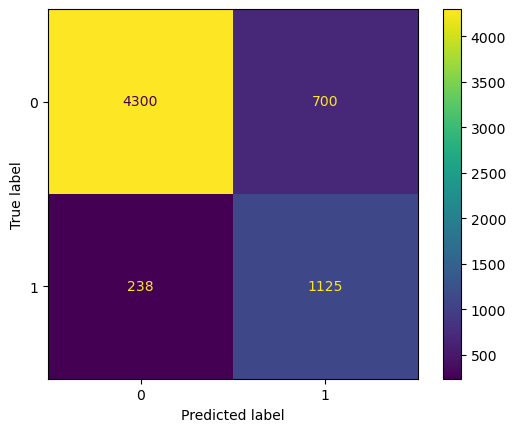

In [97]:
# Baseline Model 1: Weighted Logistic Regression
from sklearn.linear_model import LogisticRegression
# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights (to handle ~3.7:1 imbalance):")
print(f"  Not at-risk (0): {class_weight_dict[0]:.3f}")
print(f"  At-risk (1): {class_weight_dict[1]:.3f}")

# Train logistic regression with class weights
lr_model = LogisticRegression(
    class_weight=class_weight_dict,#'balanced',  # Automatically balances classes
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print("BASELINE MODEL: WEIGHTED LOGISTIC REGRESSION")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Not At-Risk', 'At-Risk']))

roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
f1_macro_lr = f1_score(y_test, y_pred_lr, average='macro')

print(f"\nPerformance Metrics:")
print(f"  ROC-AUC Score: {roc_auc_lr:.4f}")
print(f"  Macro F1 Score: {f1_macro_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"\nConfusion Matrix:")
print(f"  True Negatives (TN): {cm_lr[0,0]:,}")
print(f"  False Positives (FP): {cm_lr[0,1]:,}")
print(f"  False Negatives (FN): {cm_lr[1,0]:,}")
print(f"  True Positives (TP): {cm_lr[1,1]:,}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                              display_labels=lr_model.classes_)
disp.plot()
plt.show()
# Store results for comparison
results = {
    'Logistic Regression': {
        'roc_auc': roc_auc_lr,
        'f1_macro': f1_macro_lr,
        'y_pred_proba': y_pred_proba_lr,
        'y_pred': y_pred_lr
    }
}

At first glance this model seems to do decent if we look at the macro stats such as ROC-AUC but this is exactly why we have the classification report to break it down by predicting category and give us a much more accurate view of the models performance, We can see that the model performs really well on the not at risk predictions, there is enough data for it (comparing support in the report) and has less variance across answers from candidate to candidate. 
I am not surprised with the not so great performance here. Logistic is a parametric approach and with so many features that are not all numeric types it is hard for logistic regression to be robust to the patterns in the data. Nevertheless, I thought that a binary classification baseline should just be a paramteric method giving us in a sense the validation that the pattern in our dataset is not as straightforward and we need more complex algorithms to break down these patterns for us. Non-parametric methods that make no assumption about the shape and characteristics of the dataset. I will be trying these next.

## Modelling: RandomForest Classifier 

EXPERIMENT 2: RANDOM FOREST CLASSIFIER

Classification Report:
              precision    recall  f1-score   support

 Not At-Risk       0.94      0.89      0.92      5000
     At-Risk       0.67      0.78      0.72      1363

    accuracy                           0.87      6363
   macro avg       0.80      0.84      0.82      6363
weighted avg       0.88      0.87      0.87      6363


Performance Metrics:
  ROC-AUC Score: 0.9245
  Macro F1 Score: 0.8182

Confusion Matrix:
  TN: 4,467 | FP: 533
  FN: 294 | TP: 1,069


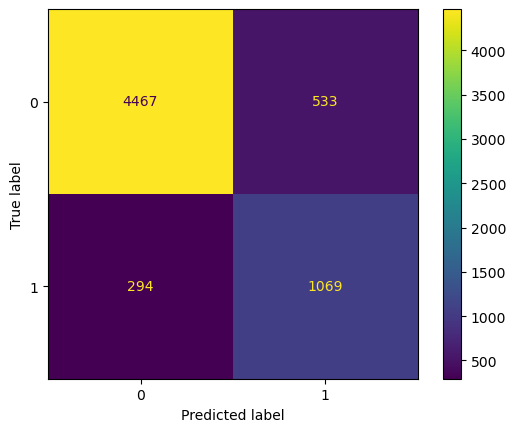


 Random Forest trained with 200 trees


In [99]:
# Experiment 2: Random Forest with class weights
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("EXPERIMENT 2: RANDOM FOREST CLASSIFIER")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Not At-Risk', 'At-Risk']))

roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')

print(f"\nPerformance Metrics:")
print(f"  ROC-AUC Score: {roc_auc_rf:.4f}")
print(f"  Macro F1 Score: {f1_macro_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"\nConfusion Matrix:")
print(f"  TN: {cm_rf[0,0]:,} | FP: {cm_rf[0,1]:,}")
print(f"  FN: {cm_rf[1,0]:,} | TP: {cm_rf[1,1]:,}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                              display_labels=rf_model.classes_)
disp.plot()
plt.show()

# Add to results
results['Random Forest'] = {
    'roc_auc': roc_auc_rf,
    'f1_macro': f1_macro_rf,
    'y_pred_proba': y_pred_proba_rf,
    'y_pred': y_pred_rf
}

print(f"\n Random Forest trained with {rf_model.n_estimators} trees")

Okay, so now I see a little bump in the performance across precison and recall for At-Risk patients. my hypothesis claims at least 70% reliability whuch I have across both macro averages but I am not satisfied with this performance. The precision measure how many predictions are actually true positives compared to those the model predicted as positive on that class. We see that at-risk is at 67% which tells us that if 50% is baseline for binary classification we barely are making the right assumption and are having a high number of false positives. Although I do have to point out that recall is doing good-ish which is to say that when there is someone actually at risk we are rarely missing on that diagnosis. Which is usually the problem we most commonly run into with imbalanced datasets. 

Next, I am trying a even more robust implementation of the tree algorithms since we have a pretty good performance here just need to boost to learn on the imbalance and really extract out differentiating patterns for at risk surveys

EXPERIMENT 3: GRADIENT BOOSTING CLASSIFIER

Classification Report:
              precision    recall  f1-score   support

 Not At-Risk       0.91      0.95      0.93      5000
     At-Risk       0.77      0.65      0.71      1363

    accuracy                           0.89      6363
   macro avg       0.84      0.80      0.82      6363
weighted avg       0.88      0.89      0.88      6363


Performance Metrics:
  ROC-AUC Score: 0.9250
  Macro F1 Score: 0.8188

Confusion Matrix:
  TN: 4,741 | FP: 259
  FN: 472 | TP: 891


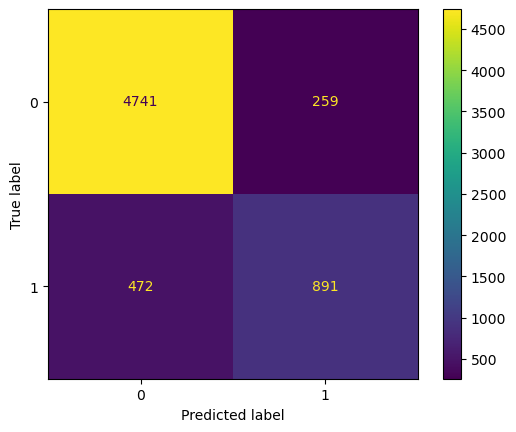


 Gradient Boosting trained with learning rate = 0.05


In [106]:
# Experiment 3: Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# Calculate scale_pos_weight for gradient boosting (handles imbalance)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    subsample=0.8,  # Use 80% of data for each tree (prevents overfitting)
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]


print("EXPERIMENT 3: GRADIENT BOOSTING CLASSIFIER")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Not At-Risk', 'At-Risk']))

roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
f1_macro_gb = f1_score(y_test, y_pred_gb, average='macro')

print(f"\nPerformance Metrics:")
print(f"  ROC-AUC Score: {roc_auc_gb:.4f}")
print(f"  Macro F1 Score: {f1_macro_gb:.4f}")

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
print(f"\nConfusion Matrix:")
print(f"  TN: {cm_gb[0,0]:,} | FP: {cm_gb[0,1]:,}")
print(f"  FN: {cm_gb[1,0]:,} | TP: {cm_gb[1,1]:,}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb,
                              display_labels=gb_model.classes_)
disp.plot()
plt.show()

# Add to results
results['Gradient Boosting'] = {
    'roc_auc': roc_auc_gb,
    'f1_macro': f1_macro_gb,
    'y_pred_proba': y_pred_proba_gb,
    'y_pred': y_pred_gb
}

print(f"\n Gradient Boosting trained with learning rate = {gb_model.learning_rate}")

## 

Oh no, looks like my gradient boosting classifier is suffering from the imbalance in the target variable, although it has stronger metrics its inflated becuase of the non-at-risk predictions - which is really not the end goal or subject of study for us. So, to be able to gauge better performance I now will try hyperparameter tunning. 

I believe given the survey data style, low row numbers and not so complex features Gradient Boosting is my best bet and Nueral Networks would probably overfit. An even better version of GB is XGB which will probaly perform the best given this survey style data -  therefore this justifies the effort spent in hyperparameter optimization as XGB is going to probaly be my final choice. 

### Hyperparameter Optimization 

First lets setup all the values and parameters we actually want to search through then we do a brute force search to find the best combination to use in the final classifier.

In [122]:
print("GRADIENT BOOSTING: TUNING FOR IMBALANCED DATA")

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.2f}:1")
print(f"This means the minority class (at-risk) is {scale_pos_weight:.2f}x smaller\n")

# Define parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 0.5, 0.7]
}

# Use macro F1 as scoring metric (treats both classes equally)
scorer = make_scorer(f1_score, average='macro')

print("Hyperparameter search space:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {np.prod([len(v) for v in param_grid.values()])}")
print("This would take too long, so we'll use RandomizedSearchCV...\n")

GRADIENT BOOSTING: TUNING FOR IMBALANCED DATA
Class imbalance ratio: 3.67:1
This means the minority class (at-risk) is 3.67x smaller

Hyperparameter search space:
  n_estimators: [200, 300, 500]
  learning_rate: [0.01, 0.05, 0.1]
  max_depth: [3, 5, 7]
  min_samples_split: [50, 100, 200]
  min_samples_leaf: [20, 50, 100]
  subsample: [0.8, 0.9, 1.0]
  max_features: ['sqrt', 0.5, 0.7]

Total combinations: 2187
This would take too long, so we'll use RandomizedSearchCV...



As mentioned above so many combinations would be computationally ery heavy and take a long time to complete and so we use optmized appraoches such as Random Search Cross Validation making splits/random sets of the data and trying the combination gives a comprehensive result given we repeat over many iterations of random samples 

In [125]:
print("RANDOMIZED SEARCH (50 iterations)")

# Randomized search
gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=50,  # Try 50 random combinations
    scoring=scorer,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on training data
gb_random.fit(X_train_scaled, y_train)


print("BEST PARAMETERS FOUND")
for param, value in gb_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Macro F1 Score: {gb_random.best_score_:.4f}")

# Evaluate best model on validation set
best_gb = gb_random.best_estimator_

y_val_pred = best_gb.predict(X_val_scaled)
y_val_proba = best_gb.predict_proba(X_val_scaled)[:, 1]

print("VALIDATION SET PERFORMANCE (Tuned Model)")
print(classification_report(y_val, y_val_pred, target_names=['Not At-Risk', 'At-Risk']))

val_roc_auc = roc_auc_score(y_val, y_val_proba)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_at_risk = f1_score(y_val, y_val_pred, pos_label=1)

print(f"ROC-AUC: {val_roc_auc:.4f}")
print(f"Macro F1: {val_f1_macro:.4f}")
print(f"F1 (At-Risk class): {val_f1_at_risk:.4f}")

cm = confusion_matrix(y_val, y_val_pred)
print(f"\nConfusion Matrix:")
print(f"  TN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
print(f"  FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print(f"\nSensitivity (Recall of At-Risk): {sensitivity:.4f} ({sensitivity*100:.1f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.1f}%)")

OPTION 1: RANDOMIZED SEARCH (50 iterations)

Starting randomized search on validation set...
This may take 5-10 minutes...

Fitting 3 folds for each of 50 candidates, totalling 150 fits

BEST PARAMETERS FOUND
  subsample: 0.8
  n_estimators: 300
  min_samples_split: 200
  min_samples_leaf: 20
  max_features: sqrt
  max_depth: 5
  learning_rate: 0.05

Best CV Macro F1 Score: 0.8196

VALIDATION SET PERFORMANCE (Tuned Model)
              precision    recall  f1-score   support

 Not At-Risk       0.91      0.95      0.93      4999
     At-Risk       0.80      0.65      0.72      1364

    accuracy                           0.89      6363
   macro avg       0.85      0.80      0.82      6363
weighted avg       0.88      0.89      0.88      6363

ROC-AUC: 0.9241
Macro F1: 0.8233
F1 (At-Risk class): 0.7154

Confusion Matrix:
  TN: 4,772 | FP: 227
  FN: 478 | TP: 886

Sensitivity (Recall of At-Risk): 0.6496 (65.0%)
Specificity: 0.9546 (95.5%)


After one round its not doing much better so letd move to XGB and see if that can be tuned (or even needs to be tuned)

## Modelling: XGradientBoosting
CLosely relsted to GB this method adds more features to adaot to mix of data types and imbalances. On reading about it turns out survey datas usually respond best to this kind of models. HEre is why I expect this approach to do the best overall:

- Handles mixed data types naturally (no need for extensive preprocessing
- Built-in regularization prevents overfitting on high-dimensional survey data
- scale_pos_weight parameter specifically designed for imbalanced data
- Faster training than Gradient Boosting
- Robust to missing data and outliers

In [133]:
import xgboost as xgb

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Class imbalance ratio: {scale_pos_weight:.2f}:1")


# Train XGBoost with optimal parameters for imbalanced data
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,  # Regularization
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    random_state=42,
    eval_metric='aucpr',  # Use PR-AUC for imbalanced data
    early_stopping_rounds=50,
    n_jobs=-1
)

print("Training XGBoost with early stopping...")
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=50
)

# Predictions
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

print("VALIDATION SET PERFORMANCE: XGBoost")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Not At-Risk', 'At-Risk']))

val_roc_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
val_f1_macro_xgb = f1_score(y_val, y_val_pred_xgb, average='macro')
val_f1_at_risk_xgb = f1_score(y_val, y_val_pred_xgb, pos_label=1)

print(f"ROC-AUC: {val_roc_auc_xgb:.4f}")
print(f"Macro F1: {val_f1_macro_xgb:.4f}")
print(f"At-Risk F1: {val_f1_at_risk_xgb:.4f}")

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
sensitivity_xgb = cm_xgb[1,1] / (cm_xgb[1,1] + cm_xgb[1,0])
print(f"\nAt-Risk Recall (Sensitivity): {sensitivity_xgb:.4f} ({sensitivity_xgb*100:.1f}%)")

Class imbalance ratio: 3.67:1
Training XGBoost with early stopping...
[0]	validation_0-aucpr:0.71454
[50]	validation_0-aucpr:0.80523
[100]	validation_0-aucpr:0.81344
[150]	validation_0-aucpr:0.81568
[182]	validation_0-aucpr:0.81446

VALIDATION SET PERFORMANCE: XGBoost
              precision    recall  f1-score   support

 Not At-Risk       0.95      0.88      0.91      4999
     At-Risk       0.65      0.82      0.72      1364

    accuracy                           0.87      6363
   macro avg       0.80      0.85      0.82      6363
weighted avg       0.88      0.87      0.87      6363

ROC-AUC: 0.9271
Macro F1: 0.8172
At-Risk F1: 0.7232

At-Risk Recall (Sensitivity): 0.8196 (82.0%)


In [148]:
print("HYPERPARAMETER OPTIMIZATION: XGBoost (RandomizedSearchCV)")

# Calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.2f}:1\n")

# Define hyperparameter search space
param_distributions = {
    'n_estimators': [300, 500, 700, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 2.0, 5.0],
}

print("Search space:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_distributions.values()])
print(f"\nTotal possible combinations: {total_combinations:,}")
print("We'll sample 50 random combinations\n")

# Base model
xgb_base = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr',
    early_stopping_rounds=50,
    n_jobs=-1
)

# Use macro F1 as scoring metric (balances both classes)
scorer = make_scorer(f1_score, average='macro')

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=50,  # Try 50 random combinations
    scoring=scorer,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# Fit - will use early stopping internally
random_search.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

print("BEST HYPERPARAMETERS FOUND")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Macro F1 Score: {random_search.best_score_:.4f}")

# Get best model
best_xgb = random_search.best_estimator_

# Evaluate on validation set
y_val_pred = best_xgb.predict(X_val_scaled)
y_val_proba = best_xgb.predict_proba(X_val_scaled)[:, 1]

print("VALIDATION SET PERFORMANCE: Tuned XGBoost")
print(classification_report(y_val, y_val_pred, target_names=['Not At-Risk', 'At-Risk']))

val_roc_auc = roc_auc_score(y_val, y_val_proba)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_at_risk = f1_score(y_val, y_val_pred, pos_label=1)

print(f"ROC-AUC: {val_roc_auc:.4f}")
print(f"Macro F1: {val_f1_macro:.4f}")
print(f"At-Risk F1: {val_f1_at_risk:.4f}")

cm = confusion_matrix(y_val, y_val_pred)
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print(f"\nConfusion Matrix:")
print(f"  TN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
print(f"  FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")
print(f"\nAt-Risk Recall (Sensitivity): {sensitivity:.4f} ({sensitivity*100:.1f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.1f}%)")

# Show top 10 parameter combinations
print("TOP 10 PARAMETER COMBINATIONS")

results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')


HYPERPARAMETER OPTIMIZATION: XGBoost (RandomizedSearchCV)
Class imbalance ratio: 3.67:1

Search space:
  n_estimators: [300, 500, 700, 1000]
  learning_rate: [0.01, 0.03, 0.05, 0.07, 0.1]
  max_depth: [4, 5, 6, 7, 8]
  min_child_weight: [1, 3, 5, 7, 10]
  subsample: [0.6, 0.7, 0.8, 0.9]
  colsample_bytree: [0.6, 0.7, 0.8, 0.9]
  gamma: [0, 0.1, 0.2, 0.3, 0.5]
  reg_alpha: [0, 0.1, 0.5, 1.0]
  reg_lambda: [0.5, 1.0, 2.0, 5.0]

Total possible combinations: 640,000
We'll sample 50 random combinations

Starting randomized search...
This will take approximately 10-20 minutes...

Fitting 3 folds for each of 50 candidates, totalling 150 fits

BEST HYPERPARAMETERS FOUND
  subsample: 0.9
  reg_lambda: 2.0
  reg_alpha: 0
  n_estimators: 1000
  min_child_weight: 3
  max_depth: 8
  learning_rate: 0.07
  gamma: 0
  colsample_bytree: 0.7

Best CV Macro F1 Score: 0.8186
VALIDATION SET PERFORMANCE: Tuned XGBoost
              precision    recall  f1-score   support

 Not At-Risk       0.94      0.90  

Okay! I think it is clear that the performance metrics are not going to be jumping up much more significantly unless I make a drastic change in approach and complexity but so far I think this is where I stop so as to be able to further refine this and provide enough evaluation on it. Below I will show in detail how my model aligns with the research question but I can see that the best performance so far is XGB and is doing the best to deal with the imbalance. 

I will now use this best model parameters on my final test set and evaluate performance in detail:

## Evaluation: XGBoost

In [158]:
print("FINAL MODEL EVALUATION: XGBoost on Test Set")

# Use your best hyperparameters from tuning
best_params = {k:v for k,v in random_search.best_params_.items()}
print("Training final model on TRAIN + VALIDATION data...")
print(f"Training samples: {len(X_train) + len(X_val):,}")

# Combine train and validation for final training
X_train_full = pd.concat([X_train_scaled, X_val_scaled])
y_train_full = np.concatenate([y_train, y_val])

print(f"  Not at-risk: {(y_train_full==0).sum():,}")
print(f"  At-risk: {(y_train_full==1).sum():,}")

# Train final model
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train_full)

print("\n Final model trained")
print(f"\nTest set size: {len(X_test):,} samples")
print(f"  Not at-risk: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"  At-risk: {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")

# Get predictions on test set
y_test_pred = final_model.predict(X_test_scaled)
y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]

print("\n Test set predictions generated")

FINAL MODEL EVALUATION: XGBoost on Test Set
Training final model on TRAIN + VALIDATION data...
Training samples: 25,450
  Not at-risk: 19,996
  At-risk: 5,454

✓ Final model trained

Test set size: 6,363 samples
  Not at-risk: 5,000 (78.6%)
  At-risk: 1,363 (21.4%)

✓ Test set predictions generated


In [164]:


# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Not At-Risk', 'At-Risk'],
                          digits=4))

# Calculate comprehensive metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
test_f1_at_risk = f1_score(y_test, y_test_pred, pos_label=1)
test_avg_precision = average_precision_score(y_test, y_test_proba)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional metrics
sensitivity = tp / (tp + fn)  # Recall for at-risk
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)  # Positive Predictive Value
npv = tn / (tn + fn)  # Negative Predictive Value
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate

print("\n" + "-"*80)
print("COMPREHENSIVE METRICS")
print("-"*80)

metrics_summary = pd.DataFrame({
    'Metric': [
        'Overall Accuracy',
        'Balanced Accuracy',
        'ROC-AUC',
        'Average Precision (PR-AUC)',
        'Macro F1',
        'Weighted F1',
        'At-Risk F1',
        'Sensitivity (At-Risk Recall)',
        'Specificity',
        'Positive Predictive Value (Precision)',
        'Negative Predictive Value',
        'False Positive Rate',
        'False Negative Rate'
    ],
    'Score': [
        test_accuracy,
        test_balanced_acc,
        test_roc_auc,
        test_avg_precision,
        test_f1_macro,
        test_f1_weighted,
        test_f1_at_risk,
        sensitivity,
        specificity,
        ppv,
        npv,
        fpr,
        fnr
    ]
})

metrics_summary['Score'] = metrics_summary['Score'].apply(lambda x: f"{x:.4f}")
display(metrics_summary)

print("\n" + "-"*80)
print("CONFUSION MATRIX")
print("-"*80)
print(f"\n                 Predicted")
print(f"               Not-Risk  At-Risk")
print(f"Actual Not-Risk  {tn:5d}    {fp:5d}")
print(f"Actual At-Risk   {fn:5d}    {tp:5d}")

print(f"\nInterpretation:")
print(f"  • True Negatives: {tn:,} - Correctly identified not-at-risk")
print(f"  • False Positives: {fp:,} - Incorrectly flagged as at-risk (Type I error)")
print(f"  • False Negatives: {fn:,} - MISSED at-risk individuals (Type II error)")
print(f"  • True Positives: {tp:,} - Correctly identified at-risk")


Classification Report:
              precision    recall  f1-score   support

 Not At-Risk     0.9053    0.9468    0.9256      5000
     At-Risk     0.7654    0.6368    0.6952      1363

    accuracy                         0.8804      6363
   macro avg     0.8354    0.7918    0.8104      6363
weighted avg     0.8754    0.8804    0.8763      6363


--------------------------------------------------------------------------------
COMPREHENSIVE METRICS
--------------------------------------------------------------------------------


,Metric,Score
0,Overall Accuracy,0.8804
1,Balanced Accuracy,0.7918
2,ROC-AUC,0.9203
3,Average Precision (PR-AUC),0.8018
4,Macro F1,0.8104
5,Weighted F1,0.8763
6,At-Risk F1,0.6952
7,Sensitivity (At-Risk Recall),0.6368
8,Specificity,0.9468
9,Positive Predictive Value (Precision),0.7654



--------------------------------------------------------------------------------
CONFUSION MATRIX
--------------------------------------------------------------------------------

                 Predicted
               Not-Risk  At-Risk
Actual Not-Risk   4734      266
Actual At-Risk     495      868

Interpretation:
  • True Negatives: 4,734 - Correctly identified not-at-risk
  • False Positives: 266 - Incorrectly flagged as at-risk (Type I error)
  • False Negatives: 495 - MISSED at-risk individuals (Type II error)
  • True Positives: 868 - Correctly identified at-risk


EXPERIMENT: Binary vs Multi-Class K6 Prediction

K6 Score Distribution in Training Data:

K6 Score range: 0 to 24
Unique K6 scores: 25

K6 Score Distribution (Train set):
K6_SCORE
0.0     7804
1.0     2412
2.0     2247
3.0     1294
4.0     1240
5.0      744
6.0      784
7.0      448
8.0      412
9.0      328
10.0     277
11.0     203
12.0     216
13.0     156
14.0     135
Name: count, dtype: int64

Multi-class target shape:
  Train: (19087,) (25 classes)
  Validation: (6363,)
  Test: (6363,)

Class balance for multi-class:


,K6_Score,Count,Percentage
0,0.0,7804,40.886467
1,1.0,2412,12.636873
2,2.0,2247,11.772411
3,3.0,1294,6.779483
4,4.0,1240,6.496568
5,5.0,744,3.897941
6,6.0,784,4.107508
7,7.0,448,2.347147
8,8.0,412,2.158537
9,9.0,328,1.718447


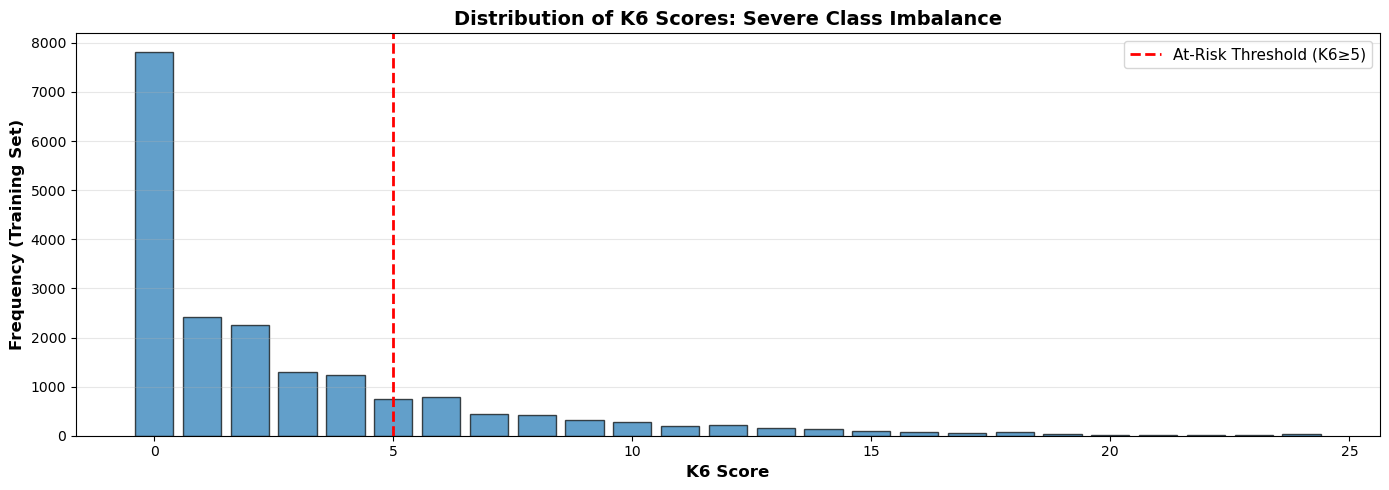


⚠️ CHALLENGE: Severe class imbalance
  Most common class (K6=0): 40.9%
  Least common classes (K6>15): <1% each


In [166]:
print("="*80)
print("EXPERIMENT: Binary vs Multi-Class K6 Prediction")
print("="*80)

import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, balanced_accuracy_score,
                             f1_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Check K6 score distribution
print("\nK6 Score Distribution in Training Data:")
k6_train = df_clean.loc[X_train.index, 'K6_SCORE']
k6_val = df_clean.loc[X_val.index, 'K6_SCORE']
k6_test = df_clean.loc[X_test.index, 'K6_SCORE']

print(f"\nK6 Score range: {k6_train.min():.0f} to {k6_train.max():.0f}")
print(f"Unique K6 scores: {k6_train.nunique()}")

# Distribution
k6_dist = k6_train.value_counts().sort_index()
print(f"\nK6 Score Distribution (Train set):")
print(k6_dist.head(15))

# Create multi-class targets
y_train_multiclass = k6_train.values
y_val_multiclass = k6_val.values
y_test_multiclass = k6_test.values

print(f"\nMulti-class target shape:")
print(f"  Train: {y_train_multiclass.shape} ({len(np.unique(y_train_multiclass))} classes)")
print(f"  Validation: {y_val_multiclass.shape}")
print(f"  Test: {y_test_multiclass.shape}")

# Check class imbalance for multi-class
unique_classes, counts = np.unique(y_train_multiclass, return_counts=True)
class_dist = pd.DataFrame({'K6_Score': unique_classes, 'Count': counts, 'Percentage': counts/counts.sum()*100})
class_dist = class_dist.sort_values('K6_Score')

print(f"\nClass balance for multi-class:")
display(class_dist)

# Visualize distribution
plt.figure(figsize=(14, 5))
plt.bar(class_dist['K6_Score'], class_dist['Count'], edgecolor='black', alpha=0.7)
plt.axvline(x=5, color='red', linestyle='--', linewidth=2, label='At-Risk Threshold (K6≥5)')
plt.xlabel('K6 Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency (Training Set)', fontsize=12, fontweight='bold')
plt.title('Distribution of K6 Scores: Severe Class Imbalance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️ CHALLENGE: Severe class imbalance")
print(f"  Most common class (K6=0): {class_dist.iloc[0]['Percentage']:.1f}%")
print(f"  Least common classes (K6>15): <1% each")

In [168]:
print("\n" + "="*80)
print("MODEL 1: BINARY CLASSIFICATION (K6 < 5 vs K6 ≥ 5)")
print("="*80)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Binary model with your best parameters
binary_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr',
    n_jobs=-1
)

print("Training binary classification model...")
binary_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

# Predictions
y_test_pred_binary = binary_model.predict(X_test_scaled)
y_test_proba_binary = binary_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*80)
print("BINARY MODEL: Test Set Performance")
print("="*80)
print(classification_report(y_test, y_test_pred_binary, 
                          target_names=['Not At-Risk', 'At-Risk'], digits=4))

# Key metrics
binary_accuracy = accuracy_score(y_test, y_test_pred_binary)
binary_balanced_acc = balanced_accuracy_score(y_test, y_test_pred_binary)
binary_roc_auc = roc_auc_score(y_test, y_test_proba_binary)
binary_f1_macro = f1_score(y_test, y_test_pred_binary, average='macro')
binary_f1_at_risk = f1_score(y_test, y_test_pred_binary, pos_label=1)

cm_binary = confusion_matrix(y_test, y_test_pred_binary)
binary_sensitivity = cm_binary[1,1] / (cm_binary[1,1] + cm_binary[1,0])
binary_specificity = cm_binary[0,0] / (cm_binary[0,0] + cm_binary[0,1])

print(f"\nBinary Model Summary:")
print(f"  Accuracy: {binary_accuracy:.4f}")
print(f"  Balanced Accuracy: {binary_balanced_acc:.4f}")
print(f"  ROC-AUC: {binary_roc_auc:.4f}")
print(f"  At-Risk Recall: {binary_sensitivity:.4f} ({binary_sensitivity*100:.1f}%)")
print(f"  At-Risk Precision: {cm_binary[1,1]/(cm_binary[1,1]+cm_binary[0,1]):.4f}")
print(f"  At-Risk F1: {binary_f1_at_risk:.4f}")

# Store results
binary_results = {
    'accuracy': binary_accuracy,
    'balanced_accuracy': binary_balanced_acc,
    'roc_auc': binary_roc_auc,
    'f1_macro': binary_f1_macro,
    'at_risk_recall': binary_sensitivity,
    'at_risk_f1': binary_f1_at_risk
}


MODEL 1: BINARY CLASSIFICATION (K6 < 5 vs K6 ≥ 5)
Training binary classification model...

BINARY MODEL: Test Set Performance
              precision    recall  f1-score   support

 Not At-Risk     0.9341    0.9036    0.9186      5000
     At-Risk     0.6841    0.7660    0.7227      1363

    accuracy                         0.8741      6363
   macro avg     0.8091    0.8348    0.8207      6363
weighted avg     0.8805    0.8741    0.8766      6363


Binary Model Summary:
  Accuracy: 0.8741
  Balanced Accuracy: 0.8348
  ROC-AUC: 0.9240
  At-Risk Recall: 0.7660 (76.6%)
  At-Risk Precision: 0.6841
  At-Risk F1: 0.7227


In [170]:
print("\n" + "="*80)
print("MODEL 2: MULTI-CLASS CLASSIFICATION (Predict Exact K6 Score 0-24)")
print("="*80)

# Multi-class XGBoost
multiclass_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='multi:softmax',  # Multi-class classification
    num_class=int(y_train_multiclass.max() + 1),  # Number of classes
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

print(f"Training multi-class model (predicting {int(y_train_multiclass.max() + 1)} K6 scores)...")
multiclass_model.fit(
    X_train_scaled, y_train_multiclass,
    eval_set=[(X_val_scaled, y_val_multiclass)],
    verbose=False
)

# Predictions
y_test_pred_multiclass = multiclass_model.predict(X_test_scaled)
y_test_proba_multiclass = multiclass_model.predict_proba(X_test_scaled)

print("\n✓ Multi-class model trained")

# Convert multi-class predictions back to binary for comparison
y_test_pred_multiclass_binary = (y_test_pred_multiclass >= 5).astype(int)

# Also get probability of being at-risk (sum probabilities for K6 ≥ 5)
y_test_proba_multiclass_at_risk = y_test_proba_multiclass[:, 5:].sum(axis=1)

print("\n" + "="*80)
print("MULTI-CLASS MODEL: Test Set Performance (Exact K6 Prediction)")
print("="*80)

# Exact match accuracy
multiclass_exact_accuracy = accuracy_score(y_test_multiclass, y_test_pred_multiclass)
print(f"Exact K6 Score Accuracy: {multiclass_exact_accuracy:.4f} ({multiclass_exact_accuracy*100:.1f}%)")
print(f"  → Model predicts EXACT K6 score correctly {multiclass_exact_accuracy*100:.1f}% of the time")

# Mean Absolute Error
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_multiclass, y_test_pred_multiclass)
rmse = np.sqrt(mean_squared_error(y_test_multiclass, y_test_pred_multiclass))

print(f"\nPrediction Error:")
print(f"  Mean Absolute Error: {mae:.2f} points")
print(f"  Root Mean Squared Error: {rmse:.2f} points")
print(f"  → On average, predictions are off by {mae:.1f} K6 points")

# Within-1-point accuracy
within_1 = np.abs(y_test_multiclass - y_test_pred_multiclass) <= 1
within_1_accuracy = within_1.mean()
print(f"\nWithin ±1 Point Accuracy: {within_1_accuracy:.4f} ({within_1_accuracy*100:.1f}%)")

within_2 = np.abs(y_test_multiclass - y_test_pred_multiclass) <= 2
within_2_accuracy = within_2.mean()
print(f"Within ±2 Points Accuracy: {within_2_accuracy:.4f} ({within_2_accuracy*100:.1f}%)")

print("\n" + "="*80)
print("MULTI-CLASS MODEL: Binary Classification Performance (K6<5 vs K6≥5)")
print("="*80)

# Evaluate as binary classifier
print(classification_report(y_test, y_test_pred_multiclass_binary,
                          target_names=['Not At-Risk', 'At-Risk'], digits=4))

multiclass_accuracy = accuracy_score(y_test, y_test_pred_multiclass_binary)
multiclass_balanced_acc = balanced_accuracy_score(y_test, y_test_pred_multiclass_binary)
multiclass_roc_auc = roc_auc_score(y_test, y_test_proba_multiclass_at_risk)
multiclass_f1_macro = f1_score(y_test, y_test_pred_multiclass_binary, average='macro')
multiclass_f1_at_risk = f1_score(y_test, y_test_pred_multiclass_binary, pos_label=1)

cm_multiclass = confusion_matrix(y_test, y_test_pred_multiclass_binary)
multiclass_sensitivity = cm_multiclass[1,1] / (cm_multiclass[1,1] + cm_multiclass[1,0])
multiclass_specificity = cm_multiclass[0,0] / (cm_multiclass[0,0] + cm_multiclass[0,1])

print(f"\nMulti-class (as Binary) Summary:")
print(f"  Binary Accuracy: {multiclass_accuracy:.4f}")
print(f"  Balanced Accuracy: {multiclass_balanced_acc:.4f}")
print(f"  ROC-AUC: {multiclass_roc_auc:.4f}")
print(f"  At-Risk Recall: {multiclass_sensitivity:.4f} ({multiclass_sensitivity*100:.1f}%)")
print(f"  At-Risk Precision: {cm_multiclass[1,1]/(cm_multiclass[1,1]+cm_multiclass[0,1]):.4f}")
print(f"  At-Risk F1: {multiclass_f1_at_risk:.4f}")

# Store results
multiclass_results = {
    'exact_accuracy': multiclass_exact_accuracy,
    'within_1_accuracy': within_1_accuracy,
    'mae': mae,
    'binary_accuracy': multiclass_accuracy,
    'balanced_accuracy': multiclass_balanced_acc,
    'roc_auc': multiclass_roc_auc,
    'f1_macro': multiclass_f1_macro,
    'at_risk_recall': multiclass_sensitivity,
    'at_risk_f1': multiclass_f1_at_risk
}


MODEL 2: MULTI-CLASS CLASSIFICATION (Predict Exact K6 Score 0-24)
Training multi-class model (predicting 25 K6 scores)...

✓ Multi-class model trained

MULTI-CLASS MODEL: Test Set Performance (Exact K6 Prediction)
Exact K6 Score Accuracy: 0.4397 (44.0%)
  → Model predicts EXACT K6 score correctly 44.0% of the time

Prediction Error:
  Mean Absolute Error: 1.57 points
  Root Mean Squared Error: 2.70 points
  → On average, predictions are off by 1.6 K6 points

Within ±1 Point Accuracy: 0.6274 (62.7%)
Within ±2 Points Accuracy: 0.7828 (78.3%)

MULTI-CLASS MODEL: Binary Classification Performance (K6<5 vs K6≥5)
              precision    recall  f1-score   support

 Not At-Risk     0.8745    0.9710    0.9202      5000
     At-Risk     0.8212    0.4886    0.6127      1363

    accuracy                         0.8677      6363
   macro avg     0.8478    0.7298    0.7665      6363
weighted avg     0.8631    0.8677    0.8543      6363


Multi-class (as Binary) Summary:
  Binary Accuracy: 0.86

In [171]:
print("\n" + "="*80)
print("HEAD-TO-HEAD COMPARISON: Binary vs Multi-Class")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': [
        'Binary Classification Accuracy',
        'Balanced Accuracy',
        'ROC-AUC',
        'Macro F1',
        'At-Risk Recall (Sensitivity)',
        'At-Risk F1',
        '---',
        'Exact K6 Score Accuracy',
        'Within ±1 Point Accuracy',
        'Mean Absolute Error (points)'
    ],
    'Binary Model': [
        f"{binary_results['accuracy']:.4f}",
        f"{binary_results['balanced_accuracy']:.4f}",
        f"{binary_results['roc_auc']:.4f}",
        f"{binary_results['f1_macro']:.4f}",
        f"{binary_results['at_risk_recall']:.4f}",
        f"{binary_results['at_risk_f1']:.4f}",
        '---',
        'N/A',
        'N/A',
        'N/A'
    ],
    'Multi-Class Model': [
        f"{multiclass_results['binary_accuracy']:.4f}",
        f"{multiclass_results['balanced_accuracy']:.4f}",
        f"{multiclass_results['roc_auc']:.4f}",
        f"{multiclass_results['f1_macro']:.4f}",
        f"{multiclass_results['at_risk_recall']:.4f}",
        f"{multiclass_results['at_risk_f1']:.4f}",
        '---',
        f"{multiclass_results['exact_accuracy']:.4f}",
        f"{multiclass_results['within_1_accuracy']:.4f}",
        f"{multiclass_results['mae']:.2f}"
    ],
    'Winner': [
        'Binary' if binary_results['accuracy'] > multiclass_results['binary_accuracy'] else 'Multi-Class',
        'Binary' if binary_results['balanced_accuracy'] > multiclass_results['balanced_accuracy'] else 'Multi-Class',
        'Binary' if binary_results['roc_auc'] > multiclass_results['roc_auc'] else 'Multi-Class',
        'Binary' if binary_results['f1_macro'] > multiclass_results['f1_macro'] else 'Multi-Class',
        'Binary' if binary_results['at_risk_recall'] > multiclass_results['at_risk_recall'] else 'Multi-Class',
        'Binary' if binary_results['at_risk_f1'] > multiclass_results['at_risk_f1'] else 'Multi-Class',
        '---',
        'Multi-Class',
        'Multi-Class',
        'Multi-Class'
    ]
})

display(comparison_df)

# Statistical comparison
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

recall_diff = binary_results['at_risk_recall'] - multiclass_results['at_risk_recall']
roc_diff = binary_results['roc_auc'] - multiclass_results['roc_auc']

print(f"\nAt-Risk Identification (Most Important for Intervention):")
print(f"  Binary Model Recall: {binary_results['at_risk_recall']*100:.1f}%")
print(f"  Multi-Class Model Recall: {multiclass_results['at_risk_recall']*100:.1f}%")
print(f"  Difference: {abs(recall_diff)*100:.1f} percentage points")

if abs(recall_diff) < 0.02:
    print(f"  → SIMILAR PERFORMANCE (difference <2%)")
elif recall_diff > 0:
    print(f"  → BINARY MODEL BETTER at catching at-risk individuals")
else:
    print(f"  → MULTI-CLASS MODEL BETTER at catching at-risk individuals")

print(f"\nDiscrimination Ability (ROC-AUC):")
print(f"  Binary Model: {binary_results['roc_auc']:.4f}")
print(f"  Multi-Class Model: {multiclass_results['roc_auc']:.4f}")
print(f"  Difference: {abs(roc_diff):.4f}")

if abs(roc_diff) < 0.01:
    print(f"  → EQUIVALENT PERFORMANCE")
elif roc_diff > 0:
    print(f"  → BINARY MODEL BETTER discrimination")
else:
    print(f"  → MULTI-CLASS MODEL BETTER discrimination")

print(f"\nAdditional Insights from Multi-Class:")
print(f"  • Exact K6 prediction: {multiclass_results['exact_accuracy']*100:.1f}% (challenging with 25 classes)")
print(f"  • Within ±1 point: {multiclass_results['within_1_accuracy']*100:.1f}%")
print(f"  • Average error: {multiclass_results['mae']:.1f} K6 points")


HEAD-TO-HEAD COMPARISON: Binary vs Multi-Class


,Metric,Binary Model,Multi-Class Model,Winner
0,Binary Classification Accuracy,0.8741,0.8677,Binary
1,Balanced Accuracy,0.8348,0.7298,Binary
2,ROC-AUC,0.9240,0.9263,Multi-Class
3,Macro F1,0.8207,0.7665,Binary
4,At-Risk Recall (Sensitivity),0.7660,0.4886,Binary
5,At-Risk F1,0.7227,0.6127,Binary
6,---,---,---,---
7,Exact K6 Score Accuracy,N/A,0.4397,Multi-Class
8,Within ±1 Point Accuracy,N/A,0.6274,Multi-Class
9,Mean Absolute Error (points),N/A,1.57,Multi-Class



KEY FINDINGS

At-Risk Identification (Most Important for Intervention):
  Binary Model Recall: 76.6%
  Multi-Class Model Recall: 48.9%
  Difference: 27.7 percentage points
  → BINARY MODEL BETTER at catching at-risk individuals

Discrimination Ability (ROC-AUC):
  Binary Model: 0.9240
  Multi-Class Model: 0.9263
  Difference: 0.0023
  → EQUIVALENT PERFORMANCE

Additional Insights from Multi-Class:
  • Exact K6 prediction: 44.0% (challenging with 25 classes)
  • Within ±1 point: 62.7%
  • Average error: 1.6 K6 points



VISUALIZATION: Model Performance Comparison


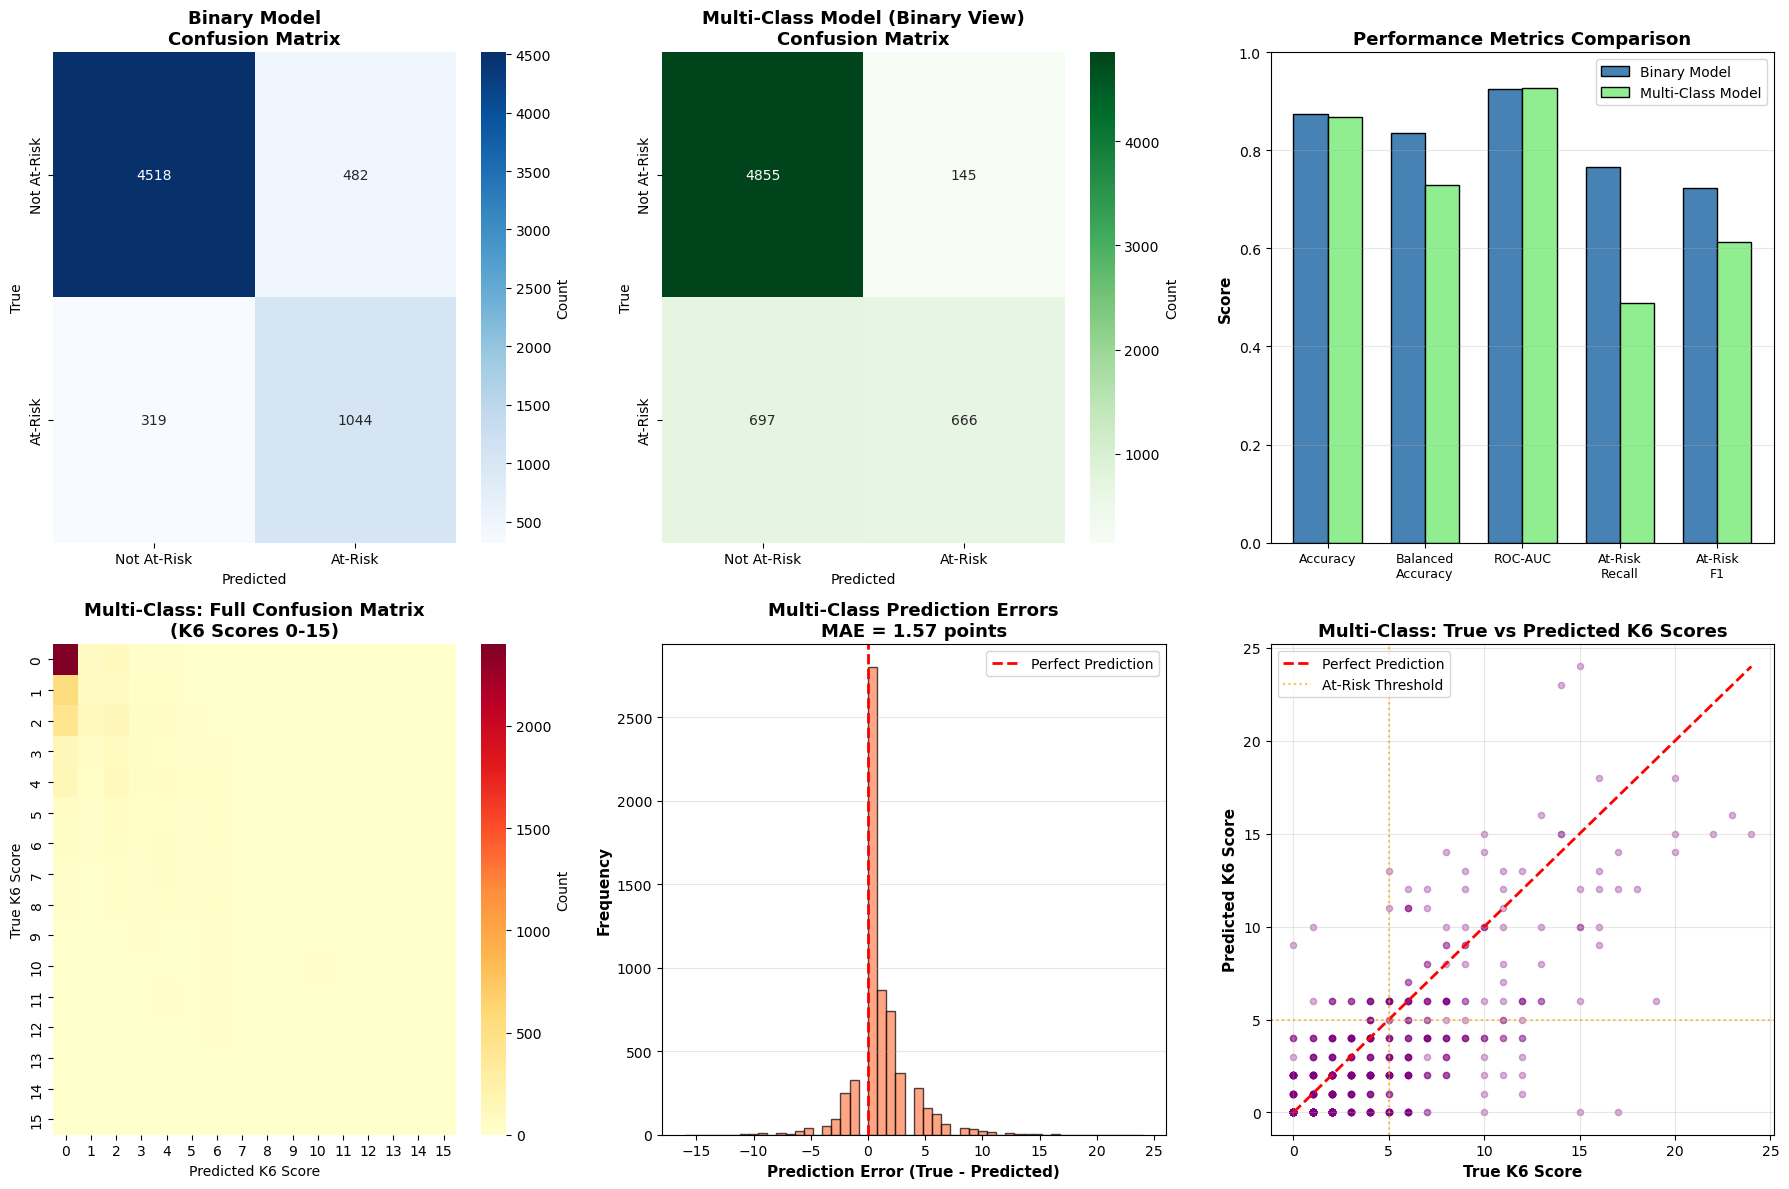

In [172]:
print("\n" + "="*80)
print("VISUALIZATION: Model Performance Comparison")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix - Binary Model
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not At-Risk', 'At-Risk'],
            yticklabels=['Not At-Risk', 'At-Risk'],
            ax=axes[0, 0], cbar_kws={'label': 'Count'})
axes[0, 0].set_title('Binary Model\nConfusion Matrix', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')

# 2. Confusion Matrix - Multi-Class (as binary)
sns.heatmap(cm_multiclass, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not At-Risk', 'At-Risk'],
            yticklabels=['Not At-Risk', 'At-Risk'],
            ax=axes[0, 1], cbar_kws={'label': 'Count'})
axes[0, 1].set_title('Multi-Class Model (Binary View)\nConfusion Matrix', 
                     fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

# 3. Metric Comparison Bar Chart
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc', 'at_risk_recall', 'at_risk_f1']
metric_labels = ['Accuracy', 'Balanced\nAccuracy', 'ROC-AUC', 'At-Risk\nRecall', 'At-Risk\nF1']

binary_vals = [binary_results[m] for m in metrics_to_plot]
multiclass_vals = [multiclass_results[m] if m in multiclass_results else multiclass_results.get('binary_'+m, 0) 
                   for m in metrics_to_plot]

x = np.arange(len(metric_labels))
width = 0.35

axes[0, 2].bar(x - width/2, binary_vals, width, label='Binary Model', 
              color='steelblue', edgecolor='black')
axes[0, 2].bar(x + width/2, multiclass_vals, width, label='Multi-Class Model',
              color='lightgreen', edgecolor='black')
axes[0, 2].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0, 2].set_title('Performance Metrics Comparison', fontsize=13, fontweight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(metric_labels, fontsize=9)
axes[0, 2].legend(fontsize=10)
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Multi-class confusion matrix (full)
# Show only K6 scores 0-15 for readability
k6_scores_to_show = [i for i in range(16)]
cm_multiclass_full = confusion_matrix(y_test_multiclass, y_test_pred_multiclass)
cm_subset = cm_multiclass_full[:16, :16]

sns.heatmap(cm_subset, annot=False, cmap='YlOrRd', ax=axes[1, 0],
           cbar_kws={'label': 'Count'})
axes[1, 0].set_title('Multi-Class: Full Confusion Matrix\n(K6 Scores 0-15)',
                    fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Predicted K6 Score')
axes[1, 0].set_ylabel('True K6 Score')

# 5. Prediction Error Distribution (Multi-class)
prediction_errors = y_test_multiclass - y_test_pred_multiclass
axes[1, 1].hist(prediction_errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Prediction Error (True - Predicted)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Multi-Class Prediction Errors\nMAE = {mae:.2f} points',
                    fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Actual vs Predicted (Multi-class) - Scatter
sample_size = min(1000, len(y_test_multiclass))
sample_idx = np.random.choice(len(y_test_multiclass), sample_size, replace=False)

axes[1, 2].scatter(y_test_multiclass[sample_idx], y_test_pred_multiclass[sample_idx],
                  alpha=0.3, s=20, color='purple')
axes[1, 2].plot([0, 24], [0, 24], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 2].axhline(5, color='orange', linestyle=':', alpha=0.7, label='At-Risk Threshold')
axes[1, 2].axvline(5, color='orange', linestyle=':', alpha=0.7)
axes[1, 2].set_xlabel('True K6 Score', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Predicted K6 Score', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Multi-Class: True vs Predicted K6 Scores',
                    fontsize=13, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()